# Pokémon Recommendation System

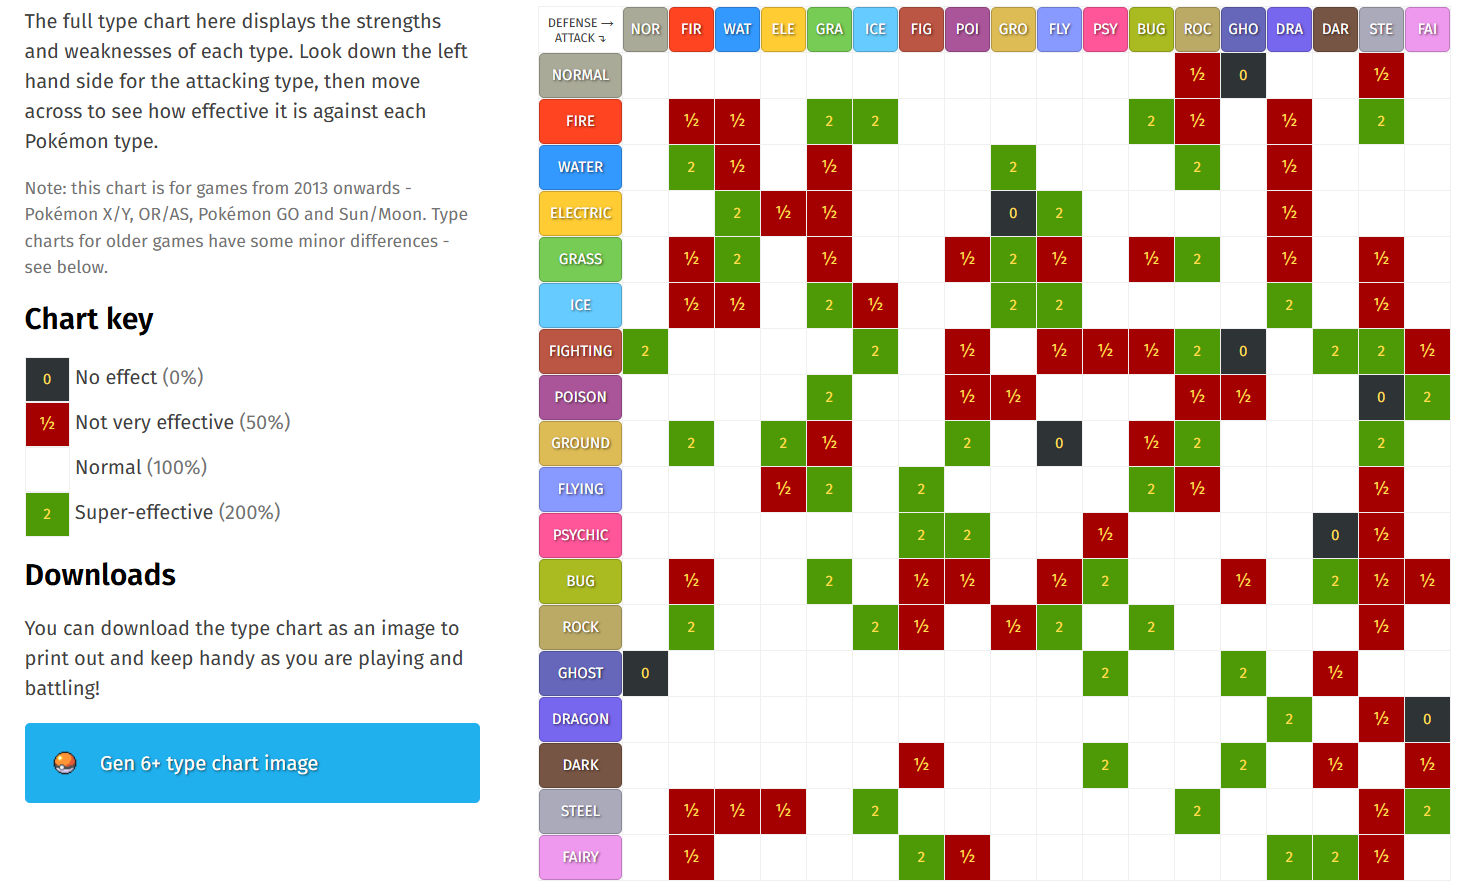

## Data Loading & Cleaning

Load the Pokémon dataset and handle missing values in Type columns.

In [42]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# LOAD DATASET
DATA_PATH = "Pokemon new dataset.csv"
df = pd.read_csv(DATA_PATH)

# Basic cleaning
df["Type 1"] = df["Type 1"].fillna("Unknown")
df["Type 2"] = df["Type 2"].fillna("None")
df = df.dropna(subset=["Legendary"])

legendary_values = df["Legendary"].copy()
df = df.drop("Legendary", axis=1)

In [43]:
df

,Unnamed: 0,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Double type,Combination type,cat,Attack index,Defense index,Strength index
0,157,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True,Electric/Flying,33,1188.5,997.0,2270.700
1,704,642,ThundurusIncarnate Forme,Electric,Flying,580,79,115,70,125,80,111,5,True,Electric/Flying,33,1188.5,997.0,2270.700
2,705,642,ThundurusTherian Forme,Electric,Flying,580,79,105,70,145,80,101,5,True,Electric/Flying,33,1188.5,997.0,2270.700
3,424,383,GroudonPrimal Groudon,Ground,Fire,770,100,180,160,150,90,90,3,True,Ground/Fire,81,1215.0,1135.0,2156.000
4,532,479,RotomHeat Rotom,Electric,Fire,520,50,65,107,105,107,86,4,True,Electric/Fire,32,1217.5,1019.5,2069.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,296,273,Seedot,Grass,None,220,40,40,50,30,30,30,3,False,Grass,66,922.5,1021.5,222.200
796,377,345,Lileep,Rock,Grass,355,66,41,77,61,87,23,3,True,Rock/Grass,124,1230.5,1374.0,200.575
797,293,270,Lotad,Water,Grass,220,40,30,30,40,50,30,3,True,Water/Grass,147,1057.5,1173.5,184.800
798,206,191,Sunkern,Grass,None,180,30,30,30,30,30,30,2,False,Grass,66,922.5,1021.5,181.800


## Categorical Features Encoding

In [44]:
# CATEGORICAL FEATURES
type1_encoder = LabelEncoder()
type2_encoder = LabelEncoder()

df["Type1_enc"] = type1_encoder.fit_transform(df["Type 1"])
df["Type2_enc"] = type2_encoder.fit_transform(df["Type 2"])

# Encode target for ML model
legendary_encoder = LabelEncoder()
y_legendary_enc = legendary_encoder.fit_transform(legendary_values)

## Feature Selection

In [45]:
# FEATURE SELECTION
FEATURE_COLUMNS = [
    "HP", "Attack", "Defense",
    "Sp. Atk", "Sp. Def", "Speed",
    "Type1_enc", "Type2_enc"
]

X_content = df[FEATURE_COLUMNS]

## Content-Based Filtering

In [46]:
# CONTENT-BASED FILTERING MODULE
scaler = StandardScaler()
content_matrix = scaler.fit_transform(X_content)

content_similarity_matrix = cosine_similarity(content_matrix)

def content_based_recommend(pokemon_index, top_n=5):
    similarity_scores = list(enumerate(content_similarity_matrix[pokemon_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    recommendations = []
    for idx, score in similarity_scores[1:top_n+1]:
        recommendations.append(df.iloc[idx]["Name"])

    return recommendations

##  Collaborative Filtering with SVD

In [47]:
# COLLABORATIVE FILTERING MODULE (SVD)
# Simulated user-Pokémon interaction matrix
np.random.seed(42)
NUM_USERS = 25
interaction_matrix = np.random.randint(0, 6, size=(NUM_USERS, len(df)))

svd = TruncatedSVD(n_components=15, random_state=42)
latent_user_matrix = svd.fit_transform(interaction_matrix)
reconstructed_matrix = np.dot(latent_user_matrix, svd.components_)

def collaborative_recommend(user_id, top_n=5):
    scores = reconstructed_matrix[user_id]
    top_indices = np.argsort(scores)[::-1][:top_n]
    return df.iloc[top_indices]["Name"].tolist()

## Normalize Collaborative Scores

In [48]:
# Normalize collaborative scores to 0–1
collab_min = reconstructed_matrix.min()
collab_max = reconstructed_matrix.max()

normalized_collab_matrix = (
    (reconstructed_matrix - collab_min) /
    (collab_max - collab_min)
)

## Machine Learning - Legendary Prediction

In [49]:
# MACHINE LEARNING MODULE
X_train, X_test, y_train, y_test = train_test_split(
    X_content, y_legendary_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_legendary_enc
)

ml_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    random_state=42
)

ml_model.fit(X_train, y_train)

# Probability score used in hybrid model
ml_strength_scores = ml_model.predict_proba(X_content)[:, 1]

# Predictions for each Pokémon (whether it's legendary)
ml_legendary_predictions = ml_model.predict(X_content)
ml_legendary_proba = ml_model.predict_proba(X_content)[:, 1]

## Type Effectiveness & Counter System

Create a type effectiveness matrix based on Pokémon type matchups. This will identify which types are super-effective (2x), normal (1x), not very effective (0.5x), or have no effect (0x) against each type.


In [ ]:
# TYPE EFFECTIVENESS MATRIX
# Based on Pokémon type chart - shows how attacking types are effective against defending types
# 2.0 = super-effective, 1.0 = normal, 0.5 = not very effective, 0.0 = no effect

types_list = ["Normal", "Fire", "Water", "Electric", "Grass", "Ice", "Fighting", 
              "Poison", "Ground", "Flying", "Psychic", "Bug", "Rock", "Ghost", 
              "Dragon", "Dark", "Steel", "Fairy"]

# Effectiveness of attacking type (rows) against defending type (columns)
type_effectiveness = {
    "Normal": {"Rock": 0.5, "Ghost": 0.0, "Steel": 0.5},
    "Fire": {"Fire": 0.5, "Water": 0.5, "Grass": 2.0, "Ice": 2.0, "Bug": 2.0, "Steel": 2.0, "Fairy": 1.0, "Rock": 0.5},
    "Water": {"Fire": 2.0, "Water": 0.5, "Grass": 0.5, "Ground": 2.0, "Rock": 2.0, "Steel": 1.0},
    "Electric": {"Water": 2.0, "Electric": 0.5, "Grass": 0.5, "Flying": 2.0, "Ground": 0.0},
    "Grass": {"Fire": 0.5, "Water": 2.0, "Grass": 0.5, "Poison": 0.5, "Ground": 2.0, "Flying": 0.5, "Bug": 0.5, "Rock": 2.0, "Steel": 0.5},
    "Ice": {"Fire": 0.5, "Water": 0.5, "Grass": 2.0, "Ice": 0.5, "Flying": 2.0, "Ground": 2.0, "Dragon": 2.0, "Steel": 0.5},
    "Fighting": {"Normal": 2.0, "Flying": 0.5, "Poison": 0.5, "Rock": 2.0, "Bug": 0.5, "Ghost": 0.0, "Dark": 2.0, "Steel": 2.0, "Fairy": 0.5, "Psychic": 0.5, "Ice": 2.0},
    "Poison": {"Grass": 2.0, "Poison": 0.5, "Ground": 0.5, "Rock": 0.5, "Ghost": 0.5, "Steel": 0.0, "Fairy": 2.0},
    "Ground": {"Fire": 2.0, "Electric": 2.0, "Grass": 0.5, "Poison": 2.0, "Flying": 0.0, "Bug": 0.5, "Rock": 2.0, "Steel": 2.0},
    "Flying": {"Fighting": 2.0, "Bug": 2.0, "Grass": 2.0, "Rock": 0.5, "Steel": 0.5, "Electric": 0.5},
    "Psychic": {"Fighting": 2.0, "Poison": 2.0, "Psychic": 0.5, "Dark": 0.0, "Steel": 0.5},
    "Bug": {"Fire": 0.5, "Grass": 2.0, "Fighting": 0.5, "Poison": 0.5, "Flying": 0.5, "Psychic": 2.0, "Ghost": 0.5, "Dark": 2.0, "Steel": 0.5, "Fairy": 0.5},
    "Rock": {"Normal": 2.0, "Fire": 2.0, "Flying": 2.0, "Bug": 2.0, "Ice": 2.0, "Fighting": 0.5, "Ground": 0.5, "Steel": 0.5},
    "Ghost": {"Poison": 2.0, "Bug": 2.0, "Ghost": 2.0, "Dark": 0.5, "Normal": 0.0},
    "Dragon": {"Dragon": 2.0, "Steel": 0.5, "Fairy": 0.0},
    "Dark": {"Fighting": 0.5, "Psychic": 2.0, "Bug": 0.5, "Dark": 0.5, "Fairy": 0.5, "Ghost": 2.0},
    "Steel": {"Normal": 2.0, "Flying": 2.0, "Rock": 2.0, "Bug": 2.0, "Steel": 0.5, "Grass": 0.5, "Psychic": 2.0, "Ice": 2.0, "Dragon": 2.0, "Fairy": 2.0, "Fire": 0.5, "Water": 0.5, "Electric": 0.5, "Poison": 0.0},
    "Fairy": {"Fighting": 2.0, "Bug": 2.0, "Dark": 2.0, "Fire": 0.5, "Poison": 0.5, "Steel": 0.5}
}

def calculate_counter_score(pokemon_index):
    indexed_type1 = df.iloc[pokemon_index]["Type 1"]
    indexed_type2 = df.iloc[pokemon_index]["Type 2"]
    
    counter_scores = np.zeros(len(df))
    
    for idx, pokemon in df.iterrows():
        attacking_type1 = pokemon["Type 1"]
        attacking_type2 = pokemon["Type 2"]
        
        # Calculate effectiveness of this Pokémon's types against the indexed Pokémon
        effectiveness = 1.0
        
        # Check Type 1 effectiveness
        if attacking_type1 in type_effectiveness:
            eff1 = type_effectiveness[attacking_type1].get(indexed_type1, 1.0)
            eff2 = type_effectiveness[attacking_type1].get(indexed_type2, 1.0) if indexed_type2 != "None" else 1.0
            effectiveness *= max(eff1, eff2)  # Take the better effectiveness
        
        # Check Type 2 effectiveness 
        if attacking_type2 != "None" and attacking_type2 in type_effectiveness:
            eff1 = type_effectiveness[attacking_type2].get(indexed_type1, 1.0)
            eff2 = type_effectiveness[attacking_type2].get(indexed_type2, 1.0) if indexed_type2 != "None" else 1.0
            effectiveness *= max(eff1, eff2)
        
        # Normalize to 0-1 scale (0 = no effectiveness, 1 = 4x super-effective)
        counter_scores[idx] = min(effectiveness / 4.0, 1.0)
    
    return counter_scores

# Pre-calculate counter scores for all Pokémon
all_counter_scores = np.zeros((len(df), len(df)))
for i in range(len(df)):
    all_counter_scores[i] = calculate_counter_score(i)


## Hybrid Recommendation Engine with Counters

In [ ]:
def hybrid_recommend_with_confidence(
    pokemon_index,
    user_id,
    top_n,
    alpha=0.30,
    beta=0.30,
    gamma=0.05,
    delta=0.35,
    filter_by_generation=True,
    prioritize_counters=True
):
    """
    Parameters:
    - pokemon_index: Index of the Pokémon to find recommendations for
    - user_id: User ID for collaborative filtering
    - top_n: Number of recommendations to return
    - alpha: Weight for content similarity(pokemon stats similarity)
    - beta: Weight for collaborative filtering(user playstyle)
    - gamma: Weight for ML confidence(legendary status)
    - delta: Weight for counter effectiveness(type counters)
    - filter_by_generation: Only recommend from same generation
    - prioritize_counters: If True, prioritize Pokémon that counter the indexed Pokémon
    """
    content_scores = content_similarity_matrix[pokemon_index]  # 0–1
    collaborative_scores = normalized_collab_matrix[user_id]   # 0–1
    ml_scores = ml_strength_scores                             # 0–1
    counter_scores = all_counter_scores[pokemon_index]         # 0–1

    if prioritize_counters:
        # Boost counter scores for priority mode
        hybrid_scores = (
            alpha * content_scores +
            beta * collaborative_scores +
            gamma * ml_scores +
            delta * counter_scores
        )
    else:
        hybrid_scores = (
            alpha * content_scores +
            beta * collaborative_scores +
            gamma * ml_scores +
            delta * counter_scores
        )

    # Get generation of indexed pokemon
    indexed_pokemon_gen = df.iloc[pokemon_index]["Generation"]

    # Apply generation filter if enabled
    if filter_by_generation:
        gen_mask = df["Generation"] == indexed_pokemon_gen
        hybrid_scores = np.where(gen_mask, hybrid_scores, -np.inf)

    top_indices = np.argsort(hybrid_scores)[::-1][:top_n]

    recommendations = []

    for idx in top_indices:
        is_legendary = bool(ml_legendary_predictions[idx])
        legendary_confidence = round(ml_legendary_proba[idx], 3)
        recommendations.append({
            "Pokemon": df.iloc[idx]["Name"],
            "Generation": int(df.iloc[idx]["Generation"]),
            "Type 1": df.iloc[idx]["Type 1"],
            "Type 2": df.iloc[idx]["Type 2"],
            "Content_Similarity": round(content_scores[idx], 3),
            "Collaborative_Score": round(collaborative_scores[idx], 3),
            "Is_Legendary": is_legendary,
            "Legendary_Confidence": legendary_confidence,
            "Counter_Effectiveness": round(counter_scores[idx], 3),
            "Final_Confidence_%": round(hybrid_scores[idx] * 100, 2)
        })

    return recommendations


## Testing the Complete Recommendation System

In [33]:
results = hybrid_recommend_with_confidence(
    pokemon_index=80,
    user_id=0,
    top_n=10
)

pokemon_index = 80
indexed_pokemon_type1 = df.iloc[pokemon_index]["Type 1"]
indexed_pokemon_type2 = df.iloc[pokemon_index]["Type 2"]
print(f"Indexed Pokemon: {df.iloc[pokemon_index]['Name']} (Gen {int(df.iloc[pokemon_index]['Generation'])}) - Type: {indexed_pokemon_type1}/{indexed_pokemon_type2}\n")

for r in results:
    print("Pokemon:", r["Pokemon"], f"({r['Type 1']}/{r['Type 2']})")
    print("Generation:", r["Generation"])
    print("Content_Similarity:", r['Content_Similarity'],"||", f"{r['Content_Similarity'] * 100:.2f}%")
    print("User Likeness?:", r['Collaborative_Score'],"||", f"{r['Collaborative_Score'] * 100:.2f}%")
    print("Is Legendary?:", r['Is_Legendary'], f"(Confidence: {r['Legendary_Confidence']:.1%})")
    print("Counter Effectiveness:", r['Counter_Effectiveness'],"||", f"{r['Counter_Effectiveness'] * 100:.2f}%")
    print("Final_Confidence_%:", r["Final_Confidence_%"],"%")
    print()


Indexed Pokemon: Genesect (Gen 5) - Type: Bug/Steel

Pokemon: Excadrill (Ground/Steel)
Generation: 5
Content_Similarity: 0.404 || 40.40%
User Likeness?: 0.653 || 65.30%
Is Legendary?: False (Confidence: 1.7%)
Counter Effectiveness: 1.0 || 100.00%
Final_Confidence_%: 66.79 %

Pokemon: LandorusIncarnate Forme (Ground/Flying)
Generation: 5
Content_Similarity: 0.414 || 41.40%
User Likeness?: 0.416 || 41.60%
Is Legendary?: True (Confidence: 80.7%)
Counter Effectiveness: 1.0 || 100.00%
Final_Confidence_%: 63.95 %

Pokemon: LandorusTherian Forme (Ground/Flying)
Generation: 5
Content_Similarity: 0.39 || 39.00%
User Likeness?: 0.415 || 41.50%
Is Legendary?: True (Confidence: 76.0%)
Counter Effectiveness: 1.0 || 100.00%
Final_Confidence_%: 62.94 %

Pokemon: Durant (Bug/Steel)
Generation: 5
Content_Similarity: 0.64 || 64.00%
User Likeness?: 0.852 || 85.20%
Is Legendary?: False (Confidence: 2.7%)
Counter Effectiveness: 0.5 || 50.00%
Final_Confidence_%: 62.38 %

Pokemon: Emboar (Fire/Fighting)
Gene

## ML legendary prediction

In [60]:
test_legendary = pd.DataFrame([{
    "HP": 90,
    "Attack": 90,
    "Defense": 85,
    "Sp. Atk": 125,
    "Sp. Def": 120,
    "Speed": 110,
    "Type1_enc": 0,  
    "Type2_enc": 0   
}])

pred = ml_model.predict(test_legendary)
prob = ml_model.predict_proba(test_legendary)

print("Prediction:", "Legendary" if pred[0] == 1 else "Not Legendary")
print("Legendary Probability:", round(prob[0][1], 3))

Prediction: Legendary
Legendary Probability: 0.607
